In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from astropy import constants as const

# Novae
Prep the list of galactic novae... we'll need distances from Gaia

So far this looks like the best single-point source for Novae:
https://github.com/Bill-Gray/galnovae

In [4]:
from astropy.table import Table

In [5]:
# cleaned up table a little bit
tbl = Table.read('galnovae.txt', format='ascii.fixed_width_no_header', 
                 col_starts=(0, 14, 19, 22, 31, 44, 59, 73, 103, 110, 118, 140), 
                 names=('NOVA', 'YEAR', 'MM', 'DD', 'VARIABLE', 'RA', 'DEC', 
                        'mags', 'T3', 'CLASS', 'OBSCURE XID', 'DISCOVERER(S)'), 
                 data_start=1)

df = tbl.to_pandas()

/Users/james/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'MM' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# c_i = SkyCoord(ra_i, dec_i, distance=dd_i)
# df_out = pd.DataFrame(data={'RA':df['RA'], 'DEC':df['DEC']})
# df_out.to_csv('galnovae.csv')

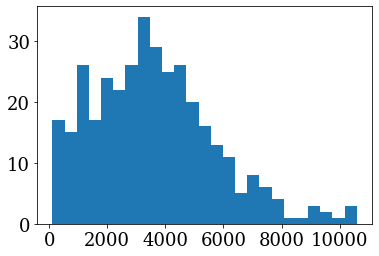

In [7]:
# gdata0 = pd.read_csv('EDR3_xmatch_2arcsec.csv')
gdata = pd.read_csv('DR2BJ_xmatch_2arcsec.csv')
# gdata.columns
_ = plt.hist(gdata['rest'], bins=25)

In [8]:
mtch = np.zeros(len(df), dtype='int')-1
# i'm too lazy to figure out the pandas merge w/ this right now...
for k in range(len(df)):
    ok = gdata['col1'] == k
    if sum(ok) > 0:
        mtch[k] = np.where(ok)[0][0]
# mtch

In [9]:
aok = np.where(np.isfinite(df['YEAR']) & np.isfinite(df['MM']) &  np.isfinite(df['DD']) & 
               (df['MM'] <= 12) & (mtch > 0) & 
               (gdata['ModFlag'].values[mtch] == 1) & 
               (gdata['ResFlag'].values[mtch] > 0))[0]
len(aok)

278

In [10]:
tt = Time({'year': df['YEAR'].values[aok], 'month': df['MM'][aok].astype('int').values, 
           'day': df['DD'][aok].astype('int').values}, format='ymdhms')

dist_err = (gdata['rest'][mtch[aok]].values - gdata['b_rest'][mtch[aok]].values) * u.pc

cc = SkyCoord(ra=gdata['RA_ICRS'][mtch[aok]].values * u.deg, 
              dec=gdata['DE_ICRS'][mtch[aok]].values * u.deg, 
              distance=gdata['rest'][mtch[aok]].values * u.pc)

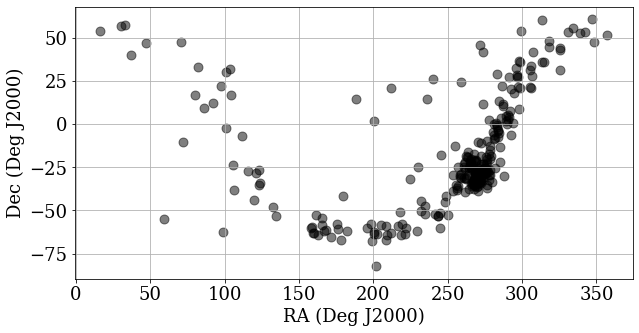

In [11]:
plt.figure(figsize=(10,5))
plt.scatter(cc.ra, cc.dec, c='k', alpha=0.5, s=80)
plt.xlabel('RA (Deg J2000)')
plt.ylabel('Dec (Deg J2000)')
# cb = plt.colorbar()
# cb.set_label('Novae Observed (Year)')
# plt.clim(1800,2020)
plt.grid(True)
plt.savefig('novae_radec.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

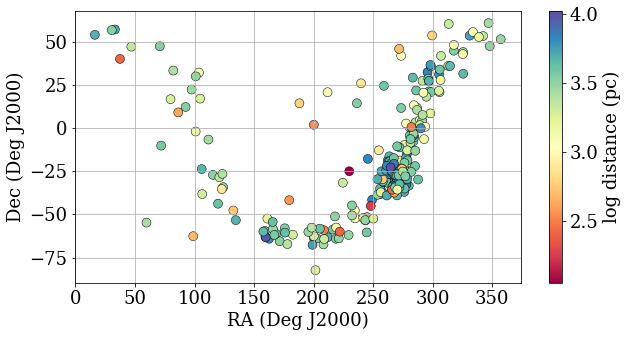

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(cc.ra, cc.dec, c=np.log10(cc.distance.value), 
            cmap=plt.cm.Spectral, edgecolors='k', lw=0.5, s=80)
plt.xlabel('RA (Deg J2000)')
plt.ylabel('Dec (Deg J2000)')
cb = plt.colorbar()
cb.set_label('log distance (pc)')
# plt.clim(1800,2020)
plt.grid(True)

In [13]:
cc.distance

<Distance [ 1416.98366373,  6519.52353859,  2703.08760539,  1884.06601832,
            1726.94866833,  3414.09843211,  5402.54040206,  3999.14711036,
            2600.19314642,  1114.21308059,  3415.96716234,  3048.97198551,
            2653.78746967,  2761.2043344 ,  3328.2570442 ,  5604.79741959,
             562.10598454,  5385.78340563,  3381.93831845,  1699.45729595,
            5436.81134206,  5142.4590655 ,  1457.06759176,   678.32040203,
            4265.64769858,  5010.18821806,  8452.99701865,  4557.95651784,
            6125.65248478,  7339.18031276,  2171.51449577,  7495.58247795,
             317.09008603,  4170.50447048,  2422.45104486,  2533.62330885,
            2844.08279562,  2749.78398682,  6004.1355025 ,  3163.01221648,
            8891.60264616,  3736.70524651,  4729.62559401,  4149.55540227,
            6306.93459149,  7128.7860987 ,  3160.94064552,  2052.60020179,
            6933.68750926,  1815.66600786,  3971.28746563,  3687.97252198,
            5120.65373346

Text(0, 0.5, 'Distance (pc)')

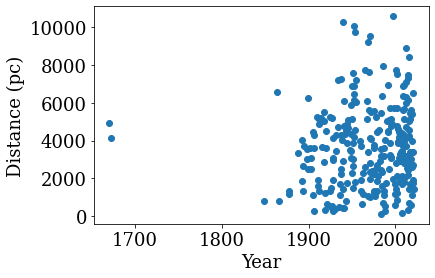

In [14]:
plt.scatter(tt.byear, cc.distance.value)
plt.xlabel('Year')
plt.ylabel('Distance (pc)')

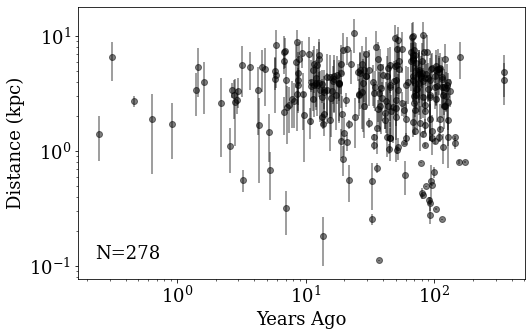

In [15]:
plt.figure(figsize=(8,5))

plt.errorbar(2021 - tt.byear, cc.distance.value/1e3, yerr = dist_err.value/1e3, 
             linestyle='none', marker='o', c='k', alpha=0.5)
plt.xlabel('Years Ago')
plt.ylabel('Distance (kpc)')
plt.xscale('log')
plt.yscale('log')

plt.text( 0.23, 1.15e-1, 'N='+str(len(aok)))
plt.savefig('novae_distances.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [16]:
# plt.scatter(gdata['rest'][mtch[aok]].values, 
#             (gdata['B_rest'][mtch[aok]].values - 
#              gdata['b_rest'][mtch[aok]].values) / gdata['rest'][mtch[aok]].values/2)

# plt.yscale('log')

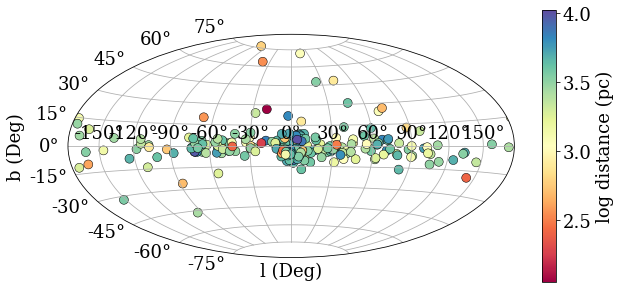

In [17]:
plt.figure(figsize=(10,5))
ax = plt.subplot(111, projection="hammer")
plt.scatter(np.deg2rad(cc.galactic.l.value), np.deg2rad(cc.galactic.b.value), 
            c=np.log10(cc.distance.value), cmap=plt.cm.Spectral, edgecolors='k', lw=0.5, s=80)
plt.scatter(np.deg2rad(cc.galactic.l.value) - (2*np.pi), np.deg2rad(cc.galactic.b.value), 
            c=np.log10(cc.distance.value), cmap=plt.cm.Spectral, edgecolors='k', lw=0.5, s=80)

plt.xlabel('l (Deg)')
plt.ylabel('b (Deg)')
cb = plt.colorbar()
cb.set_label('log distance (pc)')
plt.grid(True)